In [1]:
import tensorflow as tf
import train_helper
import helper 
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
id_to_label={0: 255, 1: 255, 2: 255, 3: 255, 4: 255, 5: 255, 6: 255, 7: 0, 8: 1, 9: 255, 10: 255, 11: 2, 12: 3, 13: 4, 14: 255, 15: 255, 16: 255, 17: 5, 18: 255, 19: 6, 20: 7, 21: 8, 22: 9, 23: 10, 24: 11, 25: 12, 26: 13, 27: 14, 28: 15, 29: 255, 30: 255, 31: 16, 32: 17, 33: 18, -1: -1}
#hasInst={0: False, 1: False, 2: False, 3: False, 4: False, 5: False, 6: False, 7: False, 8: False, 9: False, 10: False, 11: False, 12: False, 13: False, 14: False, 15: False, 16: False, 17: False, 18: False, 19: False, 20: False, 21: False, 22: False, 23: False, 24: True, 25: True, 26: True, 27: True, 28: True, 29: True, 30: True, 31: True, 32: True, 33: True, -1: False}


hasInstances={-1: False,
 0: False,
 1: False,
 2: False,
 3: False,
 4: False,
 5: False,
 6: False,
 7: False,
 8: False,
 9: False,
 10: False,
 11: True,
 12: True,
 13: True,
 14: True,
 15: True,
 16: True,
 17: True,
 18: True,
 255: True}

In [3]:
from pyclustering.cluster import cluster_visualizer;
from pyclustering.cluster.optics import optics, ordering_analyser, ordering_visualizer;

from pyclustering.utils import read_sample, timedcall;

from pyclustering.samples.definitions import SIMPLE_SAMPLES, FCPS_SAMPLES;

 

def optics_clustering(data, eps, minpts, amount_clusters = None):
    optics_instance = optics(data, eps, minpts, amount_clusters,ccore=True);
    (ticks, _) = timedcall(optics_instance.process);
    clusters = optics_instance.get_clusters();
    print(ticks)
    print('Number of clusters: ',len(clusters))
    print(sum(len(c) for c in clusters))
    return clusters,optics_instance

def visualize_cluster_distribution(data,clusters,optics_instance):
        noise = optics_instance.get_noise();
        visualizer = cluster_visualizer();
        visualizer.append_clusters(clusters, data);
        visualizer.append_cluster(noise, data, marker = 'x');
        visualizer.show();
        ordering = optics_instance.get_ordering();
        analyser = ordering_analyser(ordering);
        ordering_visualizer.show_ordering_diagram(analyser, amount_clusters);
        
def visualize_clusters(clusters,mask_for_clustering):
    maska_clusters=np.zeros(np.sum(mask_for_clustering))
    for i in range(len(clusters)):
        maska_clusters[clusters[i]]=i+1
    final_mask=np.ones(img_shape)*-1
    final_mask[np.where(mask_for_clustering)]=maska_clusters
    plt.imshow(final_mask);plt.show()

In [4]:
img_height,img_width,num_channels=288,640,3
img_shape=(288,640)
num_classes=19


def softmax(x):

    expx=np.exp(x)
    sumexp=np.sum(expx)
    #sumexp[sumexp==0]=1e-8
    return expx/sumexp

In [5]:
slim = tf.contrib.slim

def read_and_decode(filename_queue):
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    features = tf.parse_single_example(
        serialized_example,
        features={
            'height': tf.FixedLenFeature([], tf.int64),
            'width': tf.FixedLenFeature([], tf.int64),
            'depth': tf.FixedLenFeature([], tf.int64),
            'img_name': tf.FixedLenFeature([], tf.string),
            'rgb': tf.FixedLenFeature([], tf.string),
            'labels': tf.FixedLenFeature([],tf.string),
            'instances': tf.FixedLenFeature([],tf.string),
            'vector_centroid':tf.FixedLenFeature([],tf.string),
            'instance_mask': tf.FixedLenFeature([], tf.string),


        })

    
    image = tf.decode_raw(features['rgb'], tf.uint8)
    labels_unary = tf.decode_raw(features['labels'], tf.uint8)
    instances_unary=tf.decode_raw(features['instances'], tf.int16)
    instance_masku=tf.decode_raw(features['instance_mask'], tf.uint8)

    vec_cen=tf.decode_raw(features['vector_centroid'],tf.float32)



    img_name = features['img_name']


    image = tf.reshape(image, shape=[img_height, img_width, num_channels])
    image=tf.to_float(image)


    num_pixels =img_height * img_width
    labels = tf.reshape(labels_unary, shape=[num_pixels,])
    labels=tf.to_float(labels)
    labels=tf.cast(labels,tf.int32)
  

    instances=tf.reshape(instances_unary,shape=[num_pixels,])
    instance_mask=tf.reshape(instance_masku,shape=[num_pixels,])

    vector_centroid=tf.reshape(vec_cen,shape=[img_height,img_width,2])


    return (image, labels,instances,instance_mask,vector_centroid,
            img_name)

In [6]:
tfrec_dir="/home/pmarce/datasets/cityscapes/tfrecords/val"

files= glob.glob(os.path.join(tfrec_dir, '*'))

#print(files)
filename_queue = tf.train.string_input_producer(files, num_epochs=1,shuffle=False)

(image, labels, instances, instance_mask, vector_centroid,
 img_name)=read_and_decode(filename_queue)
(image, labels, instances, instance_mask, vector_centroid,
         img_name) = tf.train.batch(
            [image, labels, instances, instance_mask, vector_centroid,
         img_name], batch_size=1,num_threads=8)

In [7]:
def pyramid_pooling_layer(net,subsample_factor,img_height=288,img_width=640):
    sd = net.get_shape().as_list()[1:3]
    sd1 = [sd[0], sd[1]]
    sd2 = [sd[0]// 2, sd[1]// 2]
    sd3 = [sd1[0] // 3, sd1[1] // 3]
    sd4 = [sd1[0] // 6, sd1[1] // 6]
    upsampled_size=[img_height//subsample_factor, img_width//subsample_factor]

    first = layers.avg_pool2d(net, kernel_size=sd1)
    first_conv = layers.convolution2d(first, 128, kernel_size=1)
    first_up = tf.image.resize_bilinear(first_conv,upsampled_size , name='spp-1')

    second = layers.max_pool2d(net, kernel_size=sd2, stride=sd2)
    second_conv = layers.convolution2d(second, 128, kernel_size=1, scope='spp-2')
    second_up = tf.image.resize_bilinear(second_conv, upsampled_size, name='spp-2')

    third = layers.max_pool2d(net, kernel_size=sd3, stride=sd3)
    third_conv = layers.convolution2d(third, 128, kernel_size=1, scope='spp-3')
    third_up = tf.image.resize_bilinear(third_conv, upsampled_size, name='spp-3')

    forth = layers.max_pool2d(net, kernel_size=sd4, stride=sd4)
    forth_conv = layers.convolution2d(forth, 128, kernel_size=1, scope='spp-4')
    forth_up = tf.image.resize_bilinear(forth_conv,upsampled_size, name='spp-4')

    stacked=tf.concat([first_up,second_up,third_up,forth_up],axis=3,name='spp_global_context')
    stacked=tf.concat([net,stacked],axis=3,name='spp')




    print('result shape',stacked.get_shape())
    return stacked

In [8]:
import tensorflow.contrib.layers as layers
with tf.variable_scope('model'):
    is_training=False
    weight_decay = 5e-4
    bn_params = {
        # Decay for the moving averages.
        'decay': 0.999,
        'center': True,
        'scale': True,
        # epsilon to prevent 0s in variance.
        'epsilon': 0.001,
        # None to force the updates
        'updates_collections': None,
        'is_training': is_training,
    }
    with tf.contrib.framework.arg_scope([layers.convolution2d],
                                        kernel_size=3, stride=1, padding='SAME', rate=1, activation_fn=tf.nn.relu,
                                        # normalizer_fn=layers.batch_norm, normalizer_params=bn_params,
                                        # weights_initializer=layers.variance_scaling_initializer(),
                                        normalizer_fn=None, weights_initializer=None,
                                        weights_regularizer=layers.l2_regularizer(weight_decay)):
        net = layers.convolution2d(image, 64, scope='conv1_1')
        net = layers.convolution2d(net, 64, scope='conv1_2')
        net = layers.max_pool2d(net, 2, 2, scope='pool1')
        net = layers.convolution2d(net, 128, scope='conv2_1')
        net = layers.convolution2d(net, 128, scope='conv2_2')
        net = layers.max_pool2d(net, 2, 2, scope='pool2')
        net = layers.convolution2d(net, 256, scope='conv3_1')
        net = layers.convolution2d(net, 256, scope='conv3_2')
        net = layers.convolution2d(net, 256, scope='conv3_3')
        net = layers.max_pool2d(net, 2, 2, scope='pool3')
        net = layers.convolution2d(net, 512, scope='conv4_1')
        net = layers.convolution2d(net, 512, scope='conv4_2')
        net = layers.convolution2d(net, 512, scope='conv4_3')

        paddings = [[0, 0], [0, 0]]
        crops = [[0, 0], [0, 0]]



        block_size=2
        net=tf.space_to_batch(net,paddings=paddings,block_size=block_size)
        net = layers.convolution2d(net, 512, scope='conv5_1')
        net = layers.convolution2d(net, 512, scope='conv5_2')
        net = layers.convolution2d(net, 512, scope='conv5_3')
        net=tf.batch_to_space(net,crops=crops,block_size=block_size)


    with tf.contrib.framework.arg_scope([layers.convolution2d],stride=1,padding='SAME',
                                        weights_initializer=layers.variance_scaling_initializer(),
                                        activation_fn=tf.nn.relu,normalizer_fn=layers.batch_norm,
                                        normalizer_params=bn_params,
                                        weights_regularizer=layers.l2_regularizer(1e-3)):
        net1 = layers.convolution2d(net, 512, kernel_size=7, scope='conv6_1',rate=4)
        net1 = layers.convolution2d(net1, 512, kernel_size=3, scope='conv6_2',rate=8)

    with tf.contrib.framework.arg_scope([layers.convolution2d], stride=1, padding='SAME',
                                        weights_initializer=layers.variance_scaling_initializer(),
                                        activation_fn=tf.nn.relu, normalizer_fn=layers.batch_norm,
                                        normalizer_params=bn_params,
                                        weights_regularizer=layers.l2_regularizer(1e-3)):


        with tf.variable_scope('centers'):
            xss = layers.convolution2d(net, 512, kernel_size=7, scope='conv6_1', rate=4)
            xss = layers.convolution2d(xss, 512, kernel_size=3, scope='conv6_2', rate=2)
            xss = layers.convolution2d(xss, 512, kernel_size=3, scope='conv6_3', rate=2)

    with tf.contrib.framework.arg_scope([layers.convolution2d],stride=1,padding='SAME',
                                        weights_initializer=layers.variance_scaling_initializer(),
                                        weights_regularizer=layers.l2_regularizer(1e-3)):

        logits = layers.convolution2d(net1, num_classes, 1,padding='SAME', activation_fn=None,scope='unary_2')
        xss=layers.convolution2d(xss, 2, 1 ,padding='SAME', activation_fn=None,scope='centroid_regression')

    xss = tf.image.resize_bilinear(xss,[img_height,img_width],name='vector_to_centroid')
    logits=tf.image.resize_bilinear(logits,[img_height,img_width],name='resize_score')
    print('logits',logits.get_shape(),xss.get_shape())

logits (1, 288, 640, 19) (1, 288, 640, 2)


In [9]:
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
sess = tf.InteractiveSession(config=config)
saver = tf.train.Saver(tf.global_variables())
saver.restore(sess, '/home/pmarce/scp/25_6_02-36-36/model.ckpt')
#saver.restore(sess,'./weighted_loss/model.ckpt')
#sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord)

In [10]:
gt_im,lab,ins_mask,xss_val,ins_lab,vec_cent,vlog=sess.run([image,labels,instance_mask,xss,instances,vector_centroid,logits])

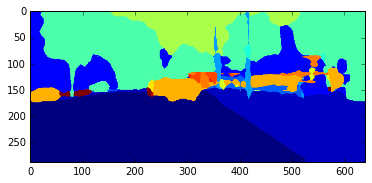

In [11]:
gt_im=np.squeeze(gt_im/255)
plt.imshow(gt_im)

lab=np.squeeze(lab)
ins_lab=np.squeeze(ins_lab)
vec_cent=np.squeeze(vec_cent)
ins_mask=np.squeeze(ins_mask).reshape(img_shape)
xss_val=np.squeeze(xss_val)
vlog=np.squeeze(vlog)
segmentation_output=vlog.argmax(2).astype(np.int32, copy=False).reshape((img_height,img_width))
y, x = np.mgrid[0:img_height, 0:img_width]
grid = np.stack((y, x), axis=-1).astype(float)
plt.imshow(segmentation_output)

In [12]:
l1_loss=np.abs(xss_val-vec_cent)
l1_loss_y=l1_loss[:,0]
l1_loss_x=l1_loss[:,1]
print(np.mean(l1_loss_y))
print(np.mean(l1_loss_x))
print(l1_loss.shape)
print(np.mean(np.sum(l1_loss,2)))

0.0171995
0.0942617
(288, 640, 2)
1.31845


In [18]:
def get_filtering_mask_by_segmentation_output(vlog,confidence_threshold=0.55):
    predicted_labels = vlog.argmax(2).astype(np.int32, copy=False).reshape((img_height,img_width))
    confidences=np.apply_along_axis(softmax,2,vlog).max(2)
    #plt.figure();plt.imshow(predicted_labels)
    #plt.figure();plt.imshow(confidences)
    lab_has_inst=np.vectorize(hasInstances.get)(predicted_labels)
    lab_hasnt_inst=~lab_has_inst
    confident=confidences>confidence_threshold
    mask_not_clustering=lab_hasnt_inst * confident
    mask_clustering=~mask_not_clustering
    return mask_clustering

def visualize_elements_on_image(points,filter_mask):
    f, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(15,8))
    #f.set_size((15,8))
    neka=np.zeros(img_shape)
    neka[np.where(filter_mask)]=(points[:,0])
    #neka.shape
    ax1.imshow(neka);ax1.set_title('y')
    neka[np.where(filter_mask)]=points[:,1]
    ax2.imshow(neka);ax2.set_title('x')
    neka[np.where(filter_mask)]=np.sum(points,1)
    ax3.imshow(neka);ax3.set_title('sum')

(12433, 2)
143 110


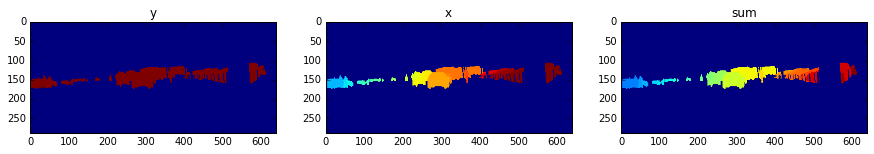

In [19]:
gt_centers=grid-vec_cent
fgt_centers=gt_centers[np.where(ins_mask)]
print(fgt_centers.shape)

visualize_elements_on_image(fgt_centers,ins_mask)



print(len(np.unique(fgt_centers[:,0])),len(np.unique(fgt_centers[:,1])))

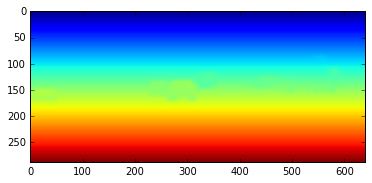

In [20]:
predicted_centers=grid-xss_val
predicted_centers.shape

plt.imshow(predicted_centers[:,:,0])

11844 11844


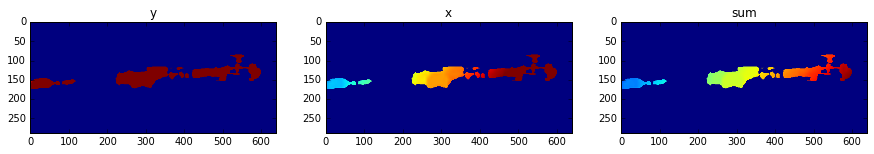

In [21]:
predicted_filter_mask=get_filtering_mask_by_segmentation_output(vlog,confidence_threshold=0.01)

points=predicted_centers[np.where(predicted_filter_mask)]

visualize_elements_on_image(points,predicted_filter_mask)

print(len(np.unique(points[:,0])),len(np.unique(points[:,1])))

In [22]:
predicted_centers_flat=predicted_centers.reshape((-1,2))
grid_flat=grid.reshape((-1,2))
x_g=np.where(np.abs(predicted_centers_flat[:,0])>grid_flat[:,0]+0.5)
y_g=np.where(np.abs(predicted_centers_flat[:,1])>grid_flat[:,1]+0.5)

mask_xyg=(np.abs(predicted_centers_flat[:,0])>grid_flat[:,0]+0.5)+(np.abs(predicted_centers_flat[:,1])>grid_flat[:,1]+0.5)
len(x_g[0]),len(y_g[0])

len(np.where(mask_xyg)[0])
#mask_xyg=x_g[0]+y_g[0]
#greater_than_grid=predicted_centers_flat[k[0],k[1]]
#greater_than_grid.shape

8733

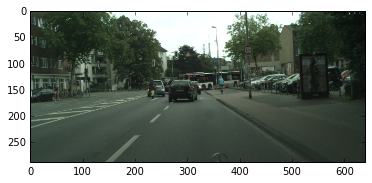

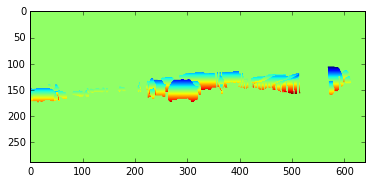

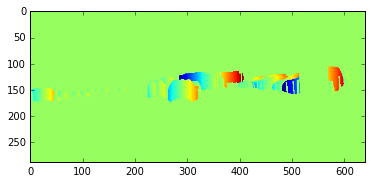

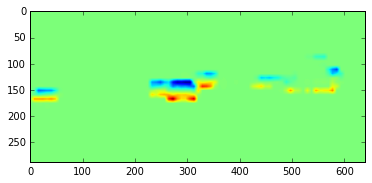

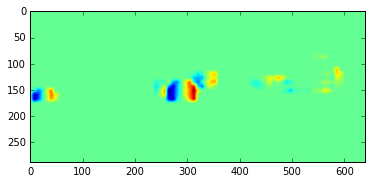

In [23]:
plt.figure();plt.imshow(gt_im)
#print(vec_cent[:,:,0][vec_cent[:,:,0]>0])
plt.figure();plt.imshow(vec_cent[:,:,0])
plt.figure();plt.imshow(vec_cent[:,:,1])
plt.figure();plt.imshow(xss_val[:,:,0])
plt.figure();plt.imshow(xss_val[:,:,1])
#plt.figure();plt.imshow(gt_centers[:,:,0])
#plt.figure();plt.imshow(gt_centers[:,:,1])
#plt.figure();plt.imshow(predicted_centers[:,:,0])
#plt.figure();plt.imshow(predicted_centers[:,:,1])

In [24]:
xss_val_x=xss_val[:,:,0]
xss_val_y=xss_val[:,:,1]
xx=np.abs(xss_val_x)>0.5
len(np.where(xx)[0])

11913

In [25]:
len(points),np.sum(predicted_filter_mask),predicted_filter_mask.shape

(11844, 11844, (288, 640))

centers.shape,predicted_centers.shape

np.mean(np.sum(np.abs(centers-predicted_centers),2))
index=200
centers[index],predicted_centers[index]

In [36]:
clusters,opt_instance=optics_clustering(points,0.5,10)

57.801438999999995
Number of clusters:  34
9141


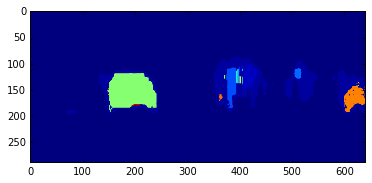

In [37]:
visualize_clusters(clusters,predicted_filter_mask)